In [18]:
import math
import librosa
import numpy as np

from numpy import argmax, diff, nonzero

def xor_based_corr(signal):
    length = signal.shape[-1]
    corr = [sum([signal[j] ^ signal[(i + j) % length] for j in range(length)]) / length for i in range(length // 2)]
    return corr

def parabolic(f, x):
    """
    Quadratic interpolation for estimating the true position of an
    inter-sample maximum when nearby samples are known.

    f is a vector and x is an index for that vector.

    Returns (vx, vy), the coordinates of the vertex of a parabola that goes
    through point x and its two neighbors.

    Example:
    Defining a vector f with a local maximum at index 3 (= 6), find local
    maximum if points 2, 3, and 4 actually defined a parabola.

    In [3]: f = [2, 3, 1, 6, 4, 2, 3, 1]

    In [4]: parabolic(f, argmax(f))
    Out[4]: (3.2142857142857144, 6.1607142857142856)
    """
    if int(x) != x:
        raise ValueError('x must be an integer sample index')
    else:
        x = int(x)
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4. * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def freq_from_obp(sig, sr):
    """
    Estimate frequency using autocorrelation
    """
    # Calculate autocorrelation and throw away the negative lags
    corr = xor_based_corr(sig)

    # Find the first low point
    d = diff(corr)
    start = nonzero(d > 0)[0][0]

    # Find the next peak after the low point (other than 0 lag).
    # Should use a weighting function to de-emphasize the peaks at longer lags.   
    peak = argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)

    return sr / px

def f0_predictor(audio, sr, win_length=1024, hop_length=256):
    sigments = librosa.util.frame(audio, frame_length=win_length, hop_length=hop_length)
    f0 = np.array([freq_from_obp(sigments[:,i], sr) for i in range(0, sigments.shape[-1])])
    return f0

def extract_sign(audio):
    sign = []
    for i in range(audio.shape[-1]):
        if audio[i] >= 0:
            sign.append(1)
        else:
            sign.append(0)
    return np.array(sign, dtype=np.int8)

In [19]:
def freq_from_obp(sig, sr):
    """
    Estimate frequency using autocorrelation
    """
    # Calculate autocorrelation and throw away the negative lags
    corr = xor_based_corr(sig)

    # Find the first low point
    d = diff(corr)
    start = nonzero(d > 0)[0][0]

    # Find the next peak after the low point (other than 0 lag).
    # Should use a weighting function to de-emphasize the peaks at longer lags.   
    peak = argmax(corr[start:]) + start
    px, py = parabolic(corr, peak)

    return corr, peak, sr / px

In [20]:
audio, sr = librosa.load("/mnt/petrelfs/wangyuancheng/OneBitPitch/test/sawtooth_440.wav", sr=None)
sign = extract_sign(audio)

In [35]:
corr, peak, f0 = freq_from_obp(sign[1024 * 4:1024 * 5], sr)
peak, f0

(139, 316.1290322580645)

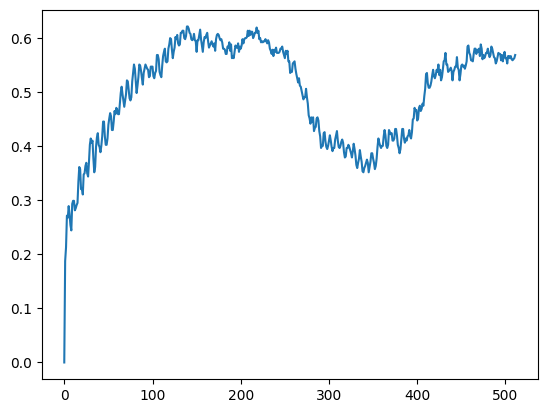

In [36]:
import matplotlib.pyplot as plt
plt.plot(corr)